In [1]:
setwd("..")

In [4]:
library(readr)
library(dplyr)
library(ggplot2)
library(ggExtra)
library(ggpubr)

## read in and format sourmash compare matrix

In [6]:
comp <- read_csv("outputs/comp/all_filt_comp_cosine.csv",
                 show_col_types = F)                      # read in mat
colnames(comp) <- gsub("_filt", "", colnames(comp))       # remove _filt from name
rownames(comp) <-colnames(comp)                           # set rownames as samples

Warning message:
“Setting row names on a tibble is deprecated.”


## read in and format metadata

In [8]:
info <- read_tsv("inputs/working_metadata.tsv", show_col_types = F) %>%
  filter(library_name %in% colnames(comp)) %>%
  group_by(library_name, study_accession, diagnosis, subject) %>%
  summarise(read_count = sum(read_count)) %>%
  as.data.frame()

`summarise()` has grouped output by 'library_name', 'study_accession', 'diagnosis'. You can override using the
`.groups` argument.


## Calculate variables for plotting

In [9]:
dist <- dist(comp)                                              # calc dist on comp mat
fit_all <- cmdscale(dist, eig = T)                              # calculate MDS
fit <- as.data.frame(fit_all$points)                            # abstract data
fit$sample <- rownames(fit)                                     # set rownames
colnames(fit) <- c("dim1", "dim2", "sample")                    # set column names
fit <- left_join(fit, info, by = c("sample" = "library_name"))  # join with metadata
var <- round(fit_all$eig*100/sum(fit_all$eig), 1)               # calc percent var

## Plot by diagnosis

In [15]:
# relevel factor so nonIBD comes first
fit$diagnosis <- factor(fit$diagnosis, levels = c("nonIBD", "CD", "UC"))

In [38]:
# make base plot
diagnosis_plt <- ggplot(fit, aes(x = dim1, y = dim2, shape = study_accession, color =diagnosis)) +
  geom_point() +
  theme_minimal() +
  ggtitle("IBD studies") +
  labs(x = paste0("PCo 1 (", var[1], "%)"),
       y = paste0("PCo 2 (", var[2], "%)")) +
  scale_shape(solid = T, name = "study") +
  scale_color_manual(name = "diagnosis", values = c("#999999", "#E69F00", "#56B4E9")) + 
  theme(plot.title = element_blank())

In [39]:
# remove the legend, as ggmarginal plots outside of legend
diagnosis_plt_final <- diagnosis_plt + theme(legend.position = "none")
# add histograms to edges of plt
diagnosis_plt_final <- ggExtra::ggMarginal(diagnosis_plt_final, type = "density",
                                           groupColour = T, groupFill = T)

In [40]:
# generate the legend from the original plot as an object
legend <- diagnosis_plt + 
  theme(legend.text=element_text(size=12),
        legend.title=element_text(size=13))
legend <- as_ggplot(get_legend(legend))

In [41]:
# join legend with plot
diagnosis_plt_final <- ggarrange(as_ggplot(diagnosis_plt_final), legend,
                                 ncol = 2, heights = 3, widths = c(2, 1))

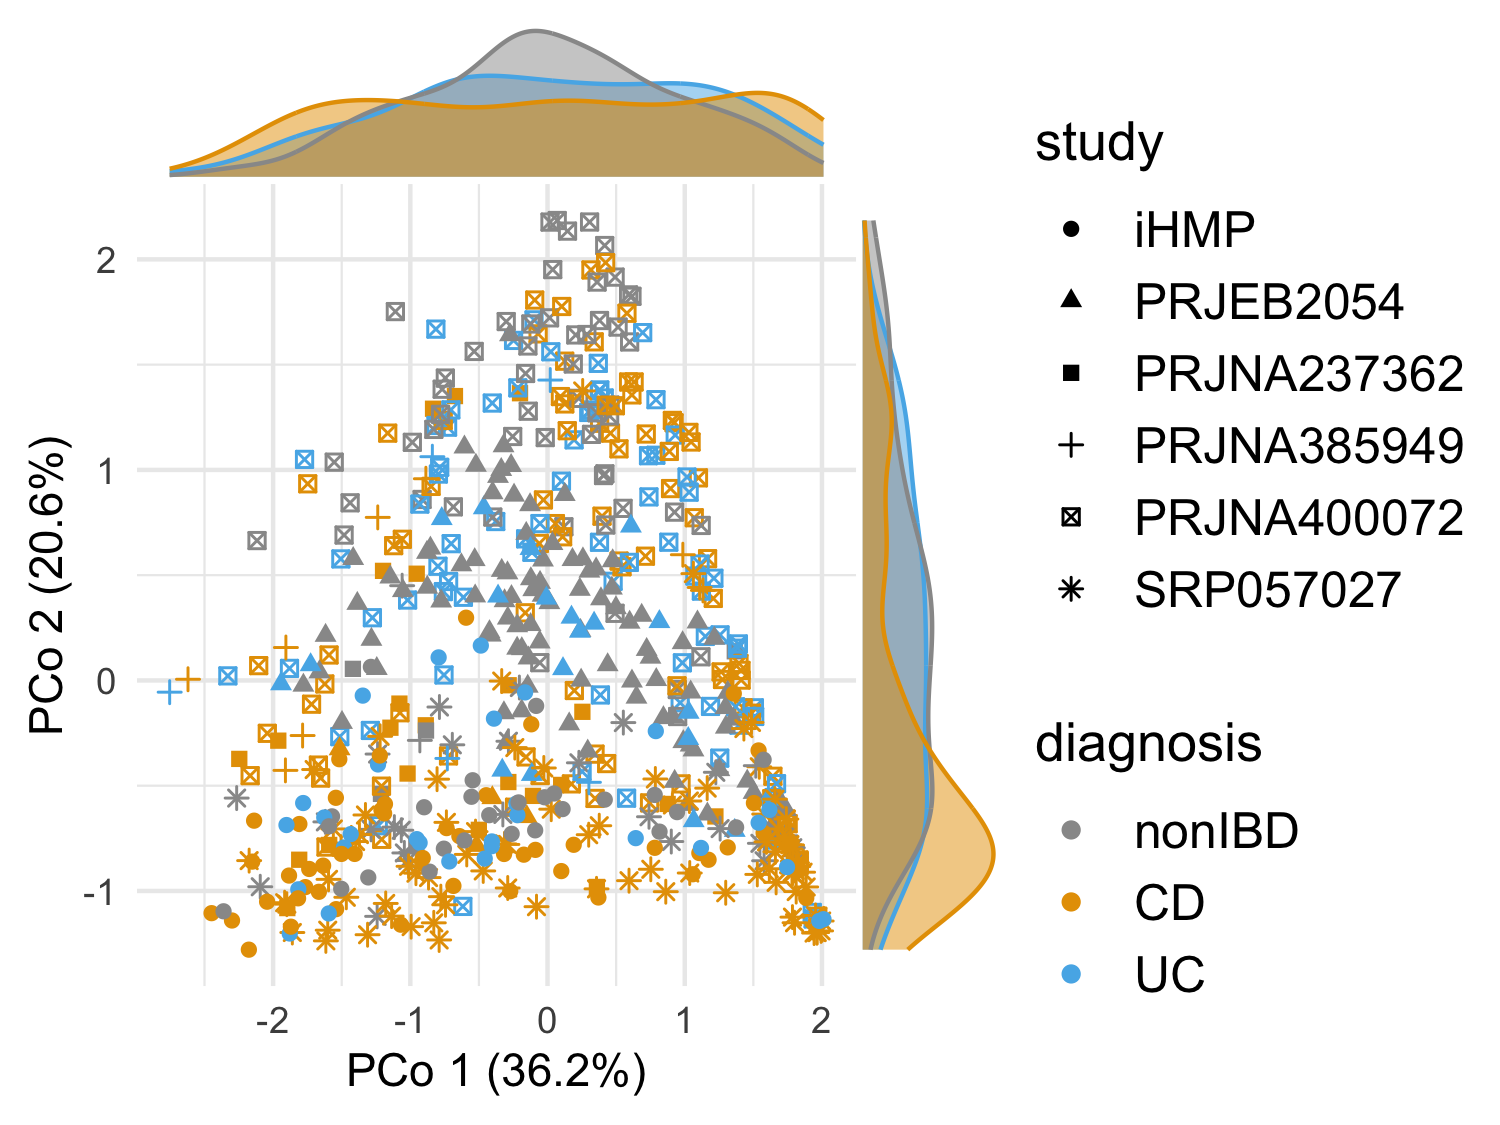

In [42]:
# adjust plot size rendered inline
options(repr.plot.width = 5, repr.plot.height = 3.75, repr.plot.res = 300)

diagnosis_plt_final